## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential issues 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set. 
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

df = pd.read_csv("sf_clean.csv") 

def district_mapping(value):
    if value in [2.0, 3.0, 10.0]:
        return "southwest"
    elif value in [1.0]:
        return "west"
    elif value in [4.0, 5.0, 6.0]:
        return "central"
    elif value in [7.0]:
        return "marina"
    elif value in [8.0]:
        return "north beach"
    else:
        return "FiDi/SOMA"
    

def parking_mapping(value):
    if value in ['(c) off-street', "(b) protected"]:
        return "off-street or prot"
    else:
        return value

df['hood_district'] = df['hood_district'].apply(district_mapping)
df["pets"] = np.where(df["pets"] == "(d) no pets", 0, 1)
df["parking"] = df["parking"].apply(parking_mapping)
df["sqft2"] = df["sqft"] ** 2
df["sqft3"] = df["sqft"] ** 3
df["laundry"] = np.where(df["laundry"] ==  "(a) in-unit", 1, 0)
df["housing_type"] = np.where(df["housing_type"] == "(a) single", 0, 1)
df["sqft_bath"] = df["sqft"] * df["bath"]
df["beds_bath_ratio"] = df["beds"] / df["bath"]
# df["price"] = np.log(df["price"])

df = df.drop([11, 253])
df = df.reset_index(drop=True)

df = pd.get_dummies(df, drop_first=True, dtype=int)


df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,sqft2,sqft3,sqft_bath,beds_bath_ratio,parking_(d) no parking,parking_off-street or prot,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800,1600.0,2.0,2.0,1,0,1,2560000.0,4.096000e+09,3200.0,1.0,0,1,0,1,0,0,0
1,3500,550.0,1.0,1.0,1,1,1,302500.0,1.663750e+08,550.0,1.0,0,1,0,1,0,0,0
2,5100,1300.0,2.0,1.0,1,1,1,1690000.0,2.197000e+09,1300.0,2.0,1,0,0,1,0,0,0
3,9000,3500.0,3.0,2.5,1,0,1,12250000.0,4.287500e+10,8750.0,1.2,0,1,0,1,0,0,0
4,3100,561.0,1.0,1.0,0,1,1,314721.0,1.765585e+08,561.0,1.0,1,0,0,1,0,0,0


In [31]:
# df["parking"].value_counts()

In [32]:
# sns.barplot(df.groupby("hood_district")["price"].mean())

In [33]:
# df.groupby("hood_district")["price"].mean()


In [34]:
# df.corr(numeric_only=True)

### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [40]:
cols = ["sqft"]

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae
from sklearn.model_selection import train_test_split

kf = KFold(n_splits=5, shuffle=True, random_state=123)

tr_r2s = []
tr_maes = []
val_r2s = []
val_maes = []

X = sm.add_constant(df[cols])
y = df["price"]
# y = np.log(df["price"])


X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


for train_ind, val_ind in kf.split(X, y):
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
    
    model = sm.OLS(y_train, X_train).fit()
    tr_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    tr_preds_orig = np.exp(tr_preds)
    y_tr_orig = np.exp(y_train)
    val_preds_orig = np.exp(val_preds)
    y_val_orig = np.exp(y_val)
    
    
    tr_r2s.append(r2(y_train, tr_preds))
    tr_maes.append(mae(y_train, tr_preds))
    val_r2s.append(r2(y_val, val_preds))
    val_maes.append(mae(y_val, val_preds))

    # tr_r2s.append(r2(y_tr_orig, tr_preds_orig))
    # tr_maes.append(mae(y_tr_orig, tr_preds_orig))
    # val_r2s.append(r2(y_val_orig, val_preds_orig))
    # val_maes.append(mae(y_val_orig, val_preds_orig))
    

# print("Train R2s: ", [round(x, 3) for x in tr_r2s])
print(f"Train r2: {round(np.mean(tr_r2s), 3)} +- {round(np.std(tr_r2s), 3)}")
print()
# print("Train MAEs: ", [round(x, 3) for x in tr_maes])
print(f"Train MAE: {round(np.mean(tr_maes), 3)} +- {round(np.std(tr_maes), 3)}")
print()

# print("Val R2s: ", [round(x, 3) for x in val_r2s])
print(f"CV r2: {round(np.mean(val_r2s), 3)} +- {round(np.std(val_r2s), 3)}")
print()
# print("Val MAEs: ", [round(x, 3) for x in val_maes])
print(f"CV MAE: {round(np.mean(val_maes), 3)} +- {round(np.std(val_maes), 3)}")

model = sm.OLS(y, X).fit()
model.summary()

Train r2: 0.722 +- 0.01

Train MAE: 528.248 +- 9.128

CV r2: 0.71 +- 0.047

CV MAE: 531.393 +- 33.296


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     2040.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):          1.00e-220
Time:                        12:04:45   Log-Likelihood:                -6351.5
No. Observations:                 789   AIC:                         1.271e+04
Df Residuals:                     787   BIC:                         1.272e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        989.4850     63.026     15.700      0.000     865.766    1113.204
sqft           2.6636      0.059     45.165      0.000       2.548       2.779
==============================================================================
Omnibus:                      252.379   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1854.064
Skew:                           1.243   Prob(JB):                         0.00
Kurtosis:                      10.087   Cond. No.                     2.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df.head()
inf_summary_df["cooks_d"].sort_values(ascending=False).round(2)

600    0.30
925    0.16
764    0.12
205    0.09
165    0.07
       ... 
726    0.00
251    0.00
217    0.00
832    0.00
645    0.00
Name: cooks_d, Length: 789, dtype: float64

## EDA


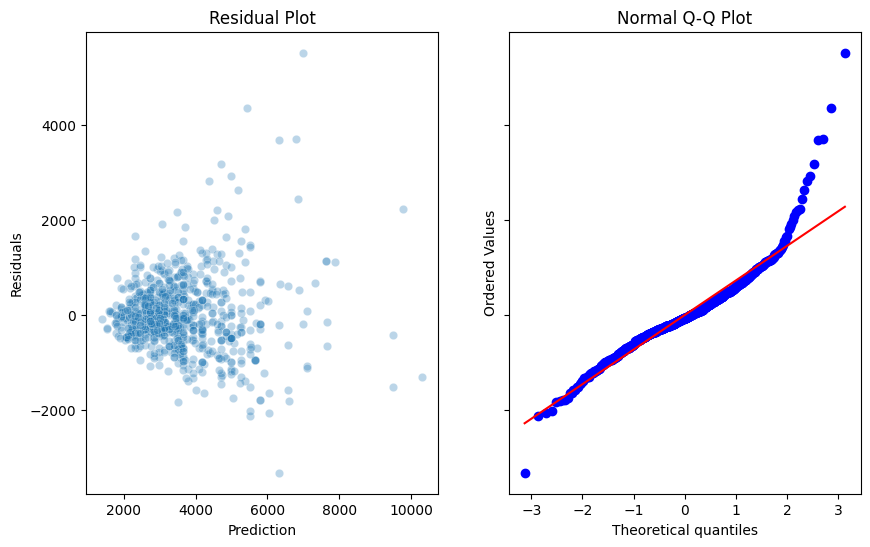

In [42]:
def residual_analysis_plots(model):

    import scipy.stats as stats
    import matplotlib.pyplot as plt

    predictions = model.predict()
    residuals = model.resid

    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=0.3)
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")

    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")

residual_analysis_plots(model)

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index = X.columns
)

const    5.436367
sqft     1.000000
dtype: float64

In [60]:
# sns.pairplot(df)

In [61]:
# print(mae(np.exp(y_test), np.exp(model.predict(X_test))))
print(f"Test MAE: {mae(y_test, model.predict(X_test))}")
print(f"Test R2: {r2(y_test, model.predict(X_test))}")

Test MAE: 442.9811273131623
Test R2: 0.7999669608223996


## Feature Engineering


## Data Splitting

In [62]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

In [64]:
from sklearn.linear_model import RidgeCV

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)
ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_tr, y)
print(ridge_model.score(X_tr, y))
print(mae(y, ridge_model.predict(X_tr)))
print(ridge_model.alpha_)

0.7860593266102469
461.82024456397187
4.768611697714469


In [65]:
list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('sqft', 827.237592734251),
 ('beds', 212.11837133034555),
 ('bath', 189.63752256975084),
 ('parking_(d) no parking', -474.24743802776015),
 ('parking_off-street or prot', -385.3359198406268),
 ('hood_district_central', 75.68811373763877),
 ('hood_district_marina', 115.88295571734767),
 ('hood_district_north beach', 31.00465652362083),
 ('hood_district_southwest', -148.2572236122835),
 ('hood_district_west', -29.556223971193866),
 ('laundry', 124.60767744337608)]

## Model Fitting & Validation Scoring

In [29]:
print(ridge_model.score(X_te, y_test))
print(mae(y_test, ridge_model.predict(X_te)))

0.7830588597082968
0.13790722071623052


## Assumptions Checking

In [46]:
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = 10 ** np.linspace(-3, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_tr, y)

print(lasso_model.score(X_tr, y))
print(mae(y, lasso_model.predict(X_tr)))
print(lasso_model.alpha_)

0.7861742667102176
462.863455588169
0.001


In [48]:
print(lasso_model.score(X_te, y_test))

0.7999671766725411


In [49]:
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('sqft', 837.4582332826195),
 ('beds', 209.41519490112648),
 ('bath', 183.95503035965353),
 ('parking_(d) no parking', -512.2541864862343),
 ('parking_off-street or prot', -422.8810813209483),
 ('hood_district_central', 78.10079493964795),
 ('hood_district_marina', 117.46452788790182),
 ('hood_district_north beach', 32.50908342806044),
 ('hood_district_southwest', -146.98032754451054),
 ('hood_district_west', -28.62588934943825),
 ('laundry', 122.82045441024431)]

## Final Model Fit & Test Scoring

In [81]:
from sklearn.linear_model import ElasticNet

enet_model = ElasticNet(alpha=1, l1_ratio=0.5).fit(X, y)

print(
    f"Train Score: {round(enet_model.score(X, y), 4)} \n"
    f"Valid Score: {round(enet_model.score(X_val, y_val), 4)}"
)

Train Score: 0.7461 
Valid Score: 0.7749


In [88]:
train_scores = []
val_scores = []

l1_ratios = np.linspace(0.01, 1, 100)

for l1_ratio in l1_ratios:
    enet_model = ElasticNet(alpha=1, l1_ratio=l1_ratio).fit(X, y)
    train_scores.append(enet_model.score(X, y))
    val_scores.append(enet_model.score(X_val, y_val))

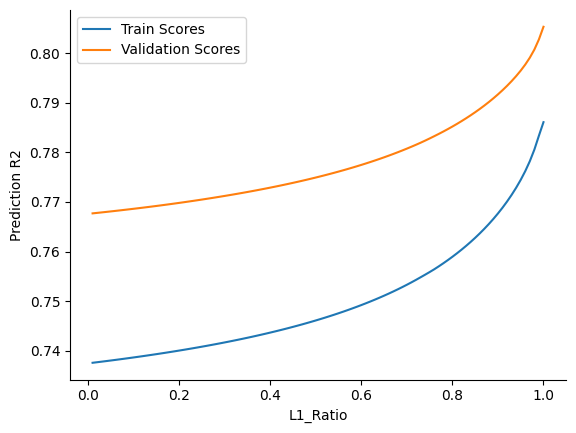

In [89]:
fig, ax = plt.subplots()

ax.plot(l1_ratios, train_scores, label = "Train Scores")
ax.plot(l1_ratios, val_scores, label = "Validation Scores")

ax.set_xlabel("L1_Ratio")
ax.set_ylabel("Prediction R2")

ax.spines[["top", "right"]].set_visible(False)
ax.legend()

In [90]:
eNet_final = ElasticNet(alpha=1.11, l1_ratio=1).fit(X, y)
eNet_final.score(X, y)

0.7860550152229333

In [91]:
eNet_final.score(X_test, y_test)

0.7997989903190604

In [92]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-3, 3, 200)
l1_ratios = np.linspace(0.01, 1, 10)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)
enet_model.fit(X, y)

print(enet_model.score(X, y))

0.7861685333752506
